## Apply Dirichlet Thompson Sampling on the Movielens Dataset
The goal is to maximize the number of relevant movie suggestions using `IndependentBandits` and `DirichletThompsonSampling`.
A rating of 4 and above is considered as positive feedback for the recommendation.

In [21]:
import numpy as np
from tqdm import tqdm
from io import BytesIO
from zipfile import ZipFile
import matplotlib.pyplot as plt
from collections import Counter
from urllib.request import urlopen


from mab_ranking.bandits.rank_bandits import IndependentBandits
from mab_ranking.bandits.bandits import DirichletThompsonSampling


In [22]:
# Helper functions


def get_movielens_data(url):
    """
    Get the movielens data
    :param url: [str], url name
    """
    data = []
    resp = urlopen(url)
    zpfile = ZipFile(BytesIO(resp.read()))
    for line in zpfile.open('ml-100k/u1.base').read().splitlines():
        data.append(
            [int(float(x)) for x in line.decode('utf-8').split('\t')])

    return np.asarray(data)


def filter_data(data):
    """
    Filters the data by keeping rating greater or equal than 4.
    Removes events that contain movies that don't belong in the top 200
    
    :param data: list[int], events data
    """
    data_pos_rating = np.asarray([x for x in data if x[2] >= 4])
    movies = [x[1] for x in data_pos_rating]
    freq = Counter(movies)
    keep_movies = [x[0] for x in freq.most_common(100)]

    filtered_data = []
    for d in data_pos_rating:
        if d[1] in keep_movies:
            filtered_data.append(d)

    return np.asarray(filtered_data)


def index_data(data):
    """
    Indexed users and movies
    
    :param data: list[int], events data
    """
    user_indexer = {v: i for i, v in enumerate(set([d[0] for d in data]))}
    movie_indexer = {v: i for i, v in enumerate(set([d[1] for d in data]))}
    indexed_data = []
    for d in data:
        d[0] = user_indexer[d[0]]
        d[1] = movie_indexer[d[1]]
        indexed_data.append(d)
    return np.asarray(indexed_data), user_indexer, movie_indexer


def running_mean(x, n):
    """
    Calculates the running mean
    """
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)


def plot_ctr(num_iterations, ctr):
    """
    Plots the CTR over time
    
    :param num_iterations: [int], number or iterations
    :param ctr: list[float], ctrs over each time step
    """
    plt.plot(range(1, num_iterations + 1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    return plt


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 18/16635 [00:00<01:36, 172.42it/s]

  0%|          | 35/16635 [00:00<01:37, 170.31it/s]

  0%|          | 52/16635 [00:00<01:38, 168.47it/s]

  0%|          | 69/16635 [00:00<01:38, 167.50it/s]

  1%|          | 87/16635 [00:00<01:38, 168.32it/s]

  1%|          | 102/16635 [00:00<01:42, 161.44it/s]

  1%|          | 118/16635 [00:00<01:44, 158.51it/s]

  1%|          | 136/16635 [00:00<01:41, 162.21it/s]

  1%|          | 154/16635 [00:00<01:40, 164.65it/s]

  1%|          | 172/16635 [00:01<01:38, 166.78it/s]

  1%|          | 189/16635 [00:01<01:38, 167.07it/s]

  1%|          | 206/16635 [00:01<01:39, 165.09it/s]

  1%|▏         | 224/16635 [00:01<01:37, 167.48it/s]

  1%|▏         | 241/16635 [00:01<01:43, 158.91it/s]

  2%|▏         | 258/16635 [00:01<01:41, 160.88it/s]

  2%|▏         | 276/16635 [00:01<01:39, 164.03it/s]

  2%|▏         | 293/16635 [00:01<01:38, 165.73it/s]

  2%|▏         | 311/16635 [00:01<01:37, 168.10it/s]

  2%|▏         | 329/16635 [00:01<01:36, 169.25it/s]

  2%|▏         | 346/16635 [00:02<01:37, 166.89it/s]

  2%|▏         | 363/16635 [00:02<01:37, 167.18it/s]

  2%|▏         | 380/16635 [00:02<01:37, 166.36it/s]

  2%|▏         | 397/16635 [00:02<01:37, 166.08it/s]

  2%|▏         | 414/16635 [00:02<01:43, 157.15it/s]

  3%|▎         | 430/16635 [00:02<01:43, 156.16it/s]

  3%|▎         | 446/16635 [00:02<01:46, 151.88it/s]

  3%|▎         | 463/16635 [00:02<01:44, 155.11it/s]

  3%|▎         | 480/16635 [00:02<01:42, 157.02it/s]

  3%|▎         | 497/16635 [00:03<01:42, 157.99it/s]

  3%|▎         | 514/16635 [00:03<01:41, 159.59it/s]

  3%|▎         | 530/16635 [00:03<01:43, 155.74it/s]

  3%|▎         | 546/16635 [00:03<01:51, 144.78it/s]

  3%|▎         | 561/16635 [00:03<01:53, 141.26it/s]

  3%|▎         | 577/16635 [00:03<01:51, 144.62it/s]

  4%|▎         | 593/16635 [00:03<01:48, 148.30it/s]

  4%|▎         | 610/16635 [00:03<01:44, 152.64it/s]

  4%|▍         | 626/16635 [00:03<01:44, 153.52it/s]

  4%|▍         | 643/16635 [00:04<01:42, 156.02it/s]

  4%|▍         | 659/16635 [00:04<01:45, 150.80it/s]

  4%|▍         | 675/16635 [00:04<01:44, 152.79it/s]

  4%|▍         | 691/16635 [00:04<01:44, 151.85it/s]

  4%|▍         | 707/16635 [00:04<01:44, 151.86it/s]

  4%|▍         | 723/16635 [00:04<01:43, 153.29it/s]

  4%|▍         | 739/16635 [00:04<01:42, 154.95it/s]

  5%|▍         | 756/16635 [00:04<01:41, 156.49it/s]

  5%|▍         | 773/16635 [00:04<01:39, 158.75it/s]

  5%|▍         | 790/16635 [00:04<01:38, 160.09it/s]

  5%|▍         | 807/16635 [00:05<01:38, 160.25it/s]

  5%|▍         | 824/16635 [00:05<01:38, 160.13it/s]

  5%|▌         | 841/16635 [00:05<01:38, 160.03it/s]

  5%|▌         | 858/16635 [00:05<01:38, 160.85it/s]

  5%|▌         | 875/16635 [00:05<01:37, 161.72it/s]

  5%|▌         | 892/16635 [00:05<01:36, 162.60it/s]

  5%|▌         | 909/16635 [00:05<01:37, 161.45it/s]

  6%|▌         | 926/16635 [00:05<01:38, 160.22it/s]

  6%|▌         | 943/16635 [00:05<01:38, 158.87it/s]

  6%|▌         | 959/16635 [00:06<01:38, 159.18it/s]

  6%|▌         | 975/16635 [00:06<01:43, 151.89it/s]

  6%|▌         | 991/16635 [00:06<01:43, 151.11it/s]

  6%|▌         | 1007/16635 [00:06<01:42, 153.19it/s]

  6%|▌         | 1023/16635 [00:06<01:43, 151.49it/s]

  6%|▌         | 1039/16635 [00:06<01:42, 152.45it/s]

  6%|▋         | 1056/16635 [00:06<01:40, 155.16it/s]

  6%|▋         | 1073/16635 [00:06<01:38, 157.27it/s]

  7%|▋         | 1089/16635 [00:06<01:38, 157.97it/s]

  7%|▋         | 1106/16635 [00:06<01:37, 158.80it/s]

  7%|▋         | 1124/16635 [00:07<01:35, 162.57it/s]

  7%|▋         | 1142/16635 [00:07<01:33, 165.56it/s]

  7%|▋         | 1159/16635 [00:07<01:33, 165.59it/s]

  7%|▋         | 1176/16635 [00:07<01:34, 163.95it/s]

  7%|▋         | 1193/16635 [00:07<01:33, 164.42it/s]

  7%|▋         | 1210/16635 [00:07<01:33, 164.39it/s]

  7%|▋         | 1227/16635 [00:07<01:33, 163.95it/s]

  7%|▋         | 1244/16635 [00:07<01:34, 162.55it/s]

  8%|▊         | 1261/16635 [00:07<01:33, 164.19it/s]

  8%|▊         | 1278/16635 [00:08<01:32, 165.19it/s]

  8%|▊         | 1295/16635 [00:08<01:33, 164.30it/s]

  8%|▊         | 1312/16635 [00:08<01:32, 165.30it/s]

  8%|▊         | 1329/16635 [00:08<01:32, 166.28it/s]

  8%|▊         | 1346/16635 [00:08<01:33, 163.60it/s]

  8%|▊         | 1363/16635 [00:08<01:34, 161.66it/s]

  8%|▊         | 1380/16635 [00:08<01:34, 161.66it/s]

  8%|▊         | 1397/16635 [00:08<01:33, 163.12it/s]

  9%|▊         | 1414/16635 [00:08<01:33, 162.26it/s]

  9%|▊         | 1432/16635 [00:08<01:32, 164.26it/s]

  9%|▊         | 1449/16635 [00:09<01:32, 164.57it/s]

  9%|▉         | 1467/16635 [00:09<01:31, 166.41it/s]

  9%|▉         | 1484/16635 [00:09<01:30, 167.37it/s]

  9%|▉         | 1501/16635 [00:09<01:30, 167.68it/s]

  9%|▉         | 1519/16635 [00:09<01:29, 168.86it/s]

  9%|▉         | 1537/16635 [00:09<01:29, 169.58it/s]

  9%|▉         | 1554/16635 [00:09<01:29, 169.22it/s]

  9%|▉         | 1571/16635 [00:09<01:31, 165.54it/s]

 10%|▉         | 1588/16635 [00:09<01:31, 164.36it/s]

 10%|▉         | 1605/16635 [00:09<01:31, 163.73it/s]

 10%|▉         | 1622/16635 [00:10<01:31, 163.35it/s]

 10%|▉         | 1639/16635 [00:10<01:31, 163.14it/s]

 10%|▉         | 1656/16635 [00:10<01:33, 161.00it/s]

 10%|█         | 1673/16635 [00:10<01:33, 160.70it/s]

 10%|█         | 1690/16635 [00:10<01:33, 159.92it/s]

 10%|█         | 1707/16635 [00:10<01:32, 162.00it/s]

 10%|█         | 1725/16635 [00:10<01:30, 164.94it/s]

 10%|█         | 1742/16635 [00:10<01:30, 165.40it/s]

 11%|█         | 1759/16635 [00:10<01:41, 147.26it/s]

 11%|█         | 1775/16635 [00:11<01:39, 148.91it/s]

 11%|█         | 1792/16635 [00:11<01:36, 153.18it/s]

 11%|█         | 1808/16635 [00:11<01:36, 153.20it/s]

 11%|█         | 1824/16635 [00:11<01:37, 152.17it/s]

 11%|█         | 1840/16635 [00:11<01:35, 154.39it/s]

 11%|█         | 1856/16635 [00:11<01:34, 155.96it/s]

 11%|█▏        | 1873/16635 [00:11<01:32, 159.88it/s]

 11%|█▏        | 1890/16635 [00:11<01:32, 160.09it/s]

 11%|█▏        | 1907/16635 [00:11<01:31, 160.88it/s]

 12%|█▏        | 1924/16635 [00:12<01:31, 161.40it/s]

 12%|█▏        | 1941/16635 [00:12<01:29, 163.28it/s]

 12%|█▏        | 1958/16635 [00:12<01:29, 164.90it/s]

 12%|█▏        | 1975/16635 [00:12<01:28, 165.38it/s]

 12%|█▏        | 1992/16635 [00:12<01:29, 164.09it/s]

 12%|█▏        | 2009/16635 [00:12<01:30, 162.33it/s]

 12%|█▏        | 2026/16635 [00:12<01:29, 163.90it/s]

 12%|█▏        | 2043/16635 [00:12<01:29, 163.69it/s]

 12%|█▏        | 2060/16635 [00:12<01:28, 165.07it/s]

 12%|█▏        | 2077/16635 [00:12<01:28, 165.11it/s]

 13%|█▎        | 2094/16635 [00:13<01:28, 165.04it/s]

 13%|█▎        | 2111/16635 [00:13<01:27, 165.22it/s]

 13%|█▎        | 2128/16635 [00:13<01:28, 163.37it/s]

 13%|█▎        | 2145/16635 [00:13<01:27, 165.21it/s]

 13%|█▎        | 2162/16635 [00:13<01:27, 164.91it/s]

 13%|█▎        | 2179/16635 [00:13<01:26, 166.33it/s]

 13%|█▎        | 2196/16635 [00:13<01:26, 166.54it/s]

 13%|█▎        | 2213/16635 [00:13<01:26, 167.06it/s]

 13%|█▎        | 2230/16635 [00:13<01:26, 166.73it/s]

 14%|█▎        | 2247/16635 [00:13<01:26, 166.90it/s]

 14%|█▎        | 2265/16635 [00:14<01:25, 168.03it/s]

 14%|█▎        | 2283/16635 [00:14<01:25, 168.56it/s]

 14%|█▍        | 2300/16635 [00:14<01:26, 166.00it/s]

 14%|█▍        | 2317/16635 [00:14<01:26, 164.73it/s]

 14%|█▍        | 2334/16635 [00:14<01:26, 164.91it/s]

 14%|█▍        | 2351/16635 [00:14<01:26, 165.68it/s]

 14%|█▍        | 2368/16635 [00:14<01:25, 166.35it/s]

 14%|█▍        | 2386/16635 [00:14<01:24, 167.74it/s]

 14%|█▍        | 2403/16635 [00:14<01:25, 166.21it/s]

 15%|█▍        | 2421/16635 [00:15<01:24, 168.43it/s]

 15%|█▍        | 2439/16635 [00:15<01:23, 169.58it/s]

 15%|█▍        | 2456/16635 [00:15<01:24, 168.22it/s]

 15%|█▍        | 2473/16635 [00:15<01:23, 168.62it/s]

 15%|█▍        | 2490/16635 [00:15<01:24, 167.01it/s]

 15%|█▌        | 2508/16635 [00:15<01:24, 167.82it/s]

 15%|█▌        | 2526/16635 [00:15<01:23, 168.70it/s]

 15%|█▌        | 2544/16635 [00:15<01:23, 169.74it/s]

 15%|█▌        | 2561/16635 [00:15<01:23, 169.38it/s]

 15%|█▌        | 2578/16635 [00:15<01:23, 168.11it/s]

 16%|█▌        | 2595/16635 [00:16<01:23, 168.20it/s]

 16%|█▌        | 2613/16635 [00:16<01:22, 168.99it/s]

 16%|█▌        | 2630/16635 [00:16<01:25, 163.88it/s]

 16%|█▌        | 2647/16635 [00:16<01:24, 165.54it/s]

 16%|█▌        | 2664/16635 [00:16<01:24, 165.41it/s]

 16%|█▌        | 2681/16635 [00:16<01:23, 166.64it/s]

 16%|█▌        | 2699/16635 [00:16<01:22, 167.99it/s]

 16%|█▋        | 2717/16635 [00:16<01:22, 168.97it/s]

 16%|█▋        | 2735/16635 [00:16<01:21, 169.99it/s]

 17%|█▋        | 2753/16635 [00:16<01:22, 169.26it/s]

 17%|█▋        | 2771/16635 [00:17<01:21, 169.85it/s]

 17%|█▋        | 2788/16635 [00:17<01:22, 168.27it/s]

 17%|█▋        | 2806/16635 [00:17<01:21, 169.13it/s]

 17%|█▋        | 2823/16635 [00:17<01:22, 167.97it/s]

 17%|█▋        | 2841/16635 [00:17<01:21, 169.08it/s]

 17%|█▋        | 2859/16635 [00:17<01:21, 169.47it/s]

 17%|█▋        | 2877/16635 [00:17<01:20, 170.50it/s]

 17%|█▋        | 2895/16635 [00:17<01:20, 170.67it/s]

 18%|█▊        | 2913/16635 [00:17<01:21, 168.80it/s]

 18%|█▊        | 2931/16635 [00:18<01:20, 169.82it/s]

 18%|█▊        | 2949/16635 [00:18<01:20, 170.44it/s]

 18%|█▊        | 2967/16635 [00:18<01:21, 167.78it/s]

 18%|█▊        | 2984/16635 [00:18<01:21, 167.62it/s]

 18%|█▊        | 3001/16635 [00:18<01:21, 167.04it/s]

 18%|█▊        | 3018/16635 [00:18<01:21, 166.87it/s]

 18%|█▊        | 3035/16635 [00:18<01:21, 166.93it/s]

 18%|█▊        | 3052/16635 [00:18<01:21, 167.42it/s]

 18%|█▊        | 3069/16635 [00:18<01:21, 166.61it/s]

 19%|█▊        | 3086/16635 [00:18<01:21, 167.24it/s]

 19%|█▊        | 3104/16635 [00:19<01:19, 169.29it/s]

 19%|█▉        | 3121/16635 [00:19<01:19, 169.00it/s]

 19%|█▉        | 3139/16635 [00:19<01:19, 170.15it/s]

 19%|█▉        | 3157/16635 [00:19<01:19, 170.17it/s]

 19%|█▉        | 3175/16635 [00:19<01:19, 168.96it/s]

 19%|█▉        | 3193/16635 [00:19<01:19, 169.70it/s]

 19%|█▉        | 3210/16635 [00:19<01:19, 169.53it/s]

 19%|█▉        | 3227/16635 [00:19<01:19, 169.53it/s]

 20%|█▉        | 3244/16635 [00:19<01:19, 168.32it/s]

 20%|█▉        | 3262/16635 [00:19<01:19, 169.27it/s]

 20%|█▉        | 3279/16635 [00:20<01:18, 169.32it/s]

 20%|█▉        | 3296/16635 [00:20<01:19, 167.50it/s]

 20%|█▉        | 3313/16635 [00:20<01:19, 167.88it/s]

 20%|██        | 3330/16635 [00:20<01:20, 165.41it/s]

 20%|██        | 3347/16635 [00:20<01:19, 166.30it/s]

 20%|██        | 3364/16635 [00:20<01:19, 167.34it/s]

 20%|██        | 3382/16635 [00:20<01:18, 168.77it/s]

 20%|██        | 3400/16635 [00:20<01:17, 169.90it/s]

 21%|██        | 3417/16635 [00:20<01:18, 167.38it/s]

 21%|██        | 3434/16635 [00:21<01:18, 168.15it/s]

 21%|██        | 3451/16635 [00:21<01:18, 168.07it/s]

 21%|██        | 3468/16635 [00:21<01:19, 165.76it/s]

 21%|██        | 3485/16635 [00:21<01:21, 162.28it/s]

 21%|██        | 3502/16635 [00:21<01:20, 162.29it/s]

 21%|██        | 3519/16635 [00:21<01:19, 164.25it/s]

 21%|██▏       | 3536/16635 [00:21<01:19, 165.61it/s]

 21%|██▏       | 3553/16635 [00:21<01:18, 166.60it/s]

 21%|██▏       | 3570/16635 [00:21<01:18, 165.90it/s]

 22%|██▏       | 3587/16635 [00:21<01:18, 165.32it/s]

 22%|██▏       | 3604/16635 [00:22<01:18, 166.14it/s]

 22%|██▏       | 3621/16635 [00:22<01:17, 166.85it/s]

 22%|██▏       | 3638/16635 [00:22<01:17, 166.98it/s]

 22%|██▏       | 3655/16635 [00:22<01:17, 167.69it/s]

 22%|██▏       | 3672/16635 [00:22<01:17, 167.16it/s]

 22%|██▏       | 3690/16635 [00:22<01:16, 168.24it/s]

 22%|██▏       | 3708/16635 [00:22<01:16, 169.26it/s]

 22%|██▏       | 3726/16635 [00:22<01:15, 170.00it/s]

 23%|██▎       | 3744/16635 [00:22<01:15, 170.34it/s]

 23%|██▎       | 3762/16635 [00:22<01:16, 168.77it/s]

 23%|██▎       | 3780/16635 [00:23<01:15, 169.49it/s]

 23%|██▎       | 3797/16635 [00:23<01:15, 169.54it/s]

 23%|██▎       | 3815/16635 [00:23<01:15, 170.13it/s]

 23%|██▎       | 3833/16635 [00:23<01:16, 168.25it/s]

 23%|██▎       | 3851/16635 [00:23<01:15, 169.47it/s]

 23%|██▎       | 3869/16635 [00:23<01:15, 169.98it/s]

 23%|██▎       | 3887/16635 [00:23<01:14, 170.75it/s]

 23%|██▎       | 3905/16635 [00:23<01:14, 171.56it/s]

 24%|██▎       | 3923/16635 [00:23<01:15, 169.24it/s]

 24%|██▎       | 3941/16635 [00:24<01:14, 170.56it/s]

 24%|██▍       | 3959/16635 [00:24<01:14, 170.81it/s]

 24%|██▍       | 3977/16635 [00:24<01:14, 170.66it/s]

 24%|██▍       | 3995/16635 [00:24<01:14, 170.22it/s]

 24%|██▍       | 4013/16635 [00:24<01:14, 169.32it/s]

 24%|██▍       | 4030/16635 [00:24<01:14, 169.51it/s]

 24%|██▍       | 4047/16635 [00:24<01:14, 168.24it/s]

 24%|██▍       | 4065/16635 [00:24<01:14, 169.82it/s]

 25%|██▍       | 4082/16635 [00:24<01:13, 169.71it/s]

 25%|██▍       | 4099/16635 [00:24<01:14, 168.91it/s]

 25%|██▍       | 4116/16635 [00:25<01:14, 169.17it/s]

 25%|██▍       | 4133/16635 [00:25<01:14, 168.12it/s]

 25%|██▍       | 4151/16635 [00:25<01:13, 169.54it/s]

 25%|██▌       | 4168/16635 [00:25<01:13, 169.28it/s]

 25%|██▌       | 4185/16635 [00:25<01:13, 169.00it/s]

 25%|██▌       | 4203/16635 [00:25<01:13, 170.25it/s]

 25%|██▌       | 4221/16635 [00:25<01:12, 170.78it/s]

 25%|██▌       | 4239/16635 [00:25<01:12, 171.37it/s]

 26%|██▌       | 4257/16635 [00:25<01:12, 169.67it/s]

 26%|██▌       | 4274/16635 [00:25<01:12, 169.72it/s]

 26%|██▌       | 4291/16635 [00:26<01:12, 169.79it/s]

 26%|██▌       | 4308/16635 [00:26<01:14, 165.63it/s]

 26%|██▌       | 4325/16635 [00:26<01:16, 161.87it/s]

 26%|██▌       | 4342/16635 [00:26<01:17, 159.00it/s]

 26%|██▌       | 4358/16635 [00:26<01:18, 156.64it/s]

 26%|██▋       | 4375/16635 [00:26<01:17, 158.22it/s]

 26%|██▋       | 4392/16635 [00:26<01:16, 160.98it/s]

 27%|██▋       | 4409/16635 [00:26<01:15, 162.74it/s]

 27%|██▋       | 4426/16635 [00:26<01:15, 162.53it/s]

 27%|██▋       | 4443/16635 [00:27<01:14, 164.16it/s]

 27%|██▋       | 4460/16635 [00:27<01:13, 165.06it/s]

 27%|██▋       | 4477/16635 [00:27<01:13, 164.56it/s]

 27%|██▋       | 4495/16635 [00:27<01:12, 167.08it/s]

 27%|██▋       | 4512/16635 [00:27<01:12, 166.58it/s]

 27%|██▋       | 4529/16635 [00:27<01:12, 167.56it/s]

 27%|██▋       | 4546/16635 [00:27<01:12, 167.66it/s]

 27%|██▋       | 4564/16635 [00:27<01:11, 168.82it/s]

 28%|██▊       | 4582/16635 [00:27<01:10, 169.78it/s]

 28%|██▊       | 4599/16635 [00:27<01:12, 165.69it/s]

 28%|██▊       | 4616/16635 [00:28<01:13, 164.11it/s]

 28%|██▊       | 4633/16635 [00:28<01:13, 162.80it/s]

 28%|██▊       | 4651/16635 [00:28<01:12, 165.06it/s]

 28%|██▊       | 4668/16635 [00:28<01:12, 164.72it/s]

 28%|██▊       | 4685/16635 [00:28<01:12, 165.41it/s]

 28%|██▊       | 4702/16635 [00:28<01:11, 165.98it/s]

 28%|██▊       | 4719/16635 [00:28<01:11, 166.60it/s]

 28%|██▊       | 4737/16635 [00:28<01:10, 167.69it/s]

 29%|██▊       | 4754/16635 [00:28<01:11, 165.78it/s]

 29%|██▊       | 4771/16635 [00:29<01:12, 164.33it/s]

 29%|██▉       | 4789/16635 [00:29<01:11, 166.02it/s]

 29%|██▉       | 4806/16635 [00:29<01:10, 167.03it/s]

 29%|██▉       | 4824/16635 [00:29<01:10, 168.19it/s]

 29%|██▉       | 4841/16635 [00:29<01:10, 166.92it/s]

 29%|██▉       | 4859/16635 [00:29<01:10, 168.20it/s]

 29%|██▉       | 4876/16635 [00:29<01:09, 168.57it/s]

 29%|██▉       | 4893/16635 [00:29<01:10, 166.76it/s]

 30%|██▉       | 4910/16635 [00:29<01:11, 165.11it/s]

 30%|██▉       | 4927/16635 [00:29<01:11, 164.75it/s]

 30%|██▉       | 4944/16635 [00:30<01:10, 165.82it/s]

 30%|██▉       | 4961/16635 [00:30<01:10, 166.62it/s]

 30%|██▉       | 4978/16635 [00:30<01:10, 165.16it/s]

 30%|███       | 4996/16635 [00:30<01:09, 167.36it/s]

 30%|███       | 5013/16635 [00:30<01:09, 167.23it/s]

 30%|███       | 5030/16635 [00:30<01:09, 167.64it/s]

 30%|███       | 5047/16635 [00:30<01:12, 158.87it/s]

 30%|███       | 5065/16635 [00:30<01:11, 162.76it/s]

 31%|███       | 5082/16635 [00:30<01:10, 164.53it/s]

 31%|███       | 5099/16635 [00:30<01:09, 165.69it/s]

 31%|███       | 5116/16635 [00:31<01:09, 166.66it/s]

 31%|███       | 5133/16635 [00:31<01:09, 166.33it/s]

 31%|███       | 5150/16635 [00:31<01:09, 165.39it/s]

 31%|███       | 5168/16635 [00:31<01:08, 166.59it/s]

 31%|███       | 5185/16635 [00:31<01:08, 166.70it/s]

 31%|███▏      | 5203/16635 [00:31<01:08, 167.94it/s]

 31%|███▏      | 5221/16635 [00:31<01:07, 168.80it/s]

 31%|███▏      | 5239/16635 [00:31<01:07, 169.78it/s]

 32%|███▏      | 5256/16635 [00:31<01:07, 167.67it/s]

 32%|███▏      | 5273/16635 [00:32<01:07, 167.59it/s]

 32%|███▏      | 5290/16635 [00:32<01:07, 167.84it/s]

 32%|███▏      | 5307/16635 [00:32<01:08, 165.78it/s]

 32%|███▏      | 5324/16635 [00:32<01:08, 166.03it/s]

 32%|███▏      | 5341/16635 [00:32<01:08, 165.13it/s]

 32%|███▏      | 5358/16635 [00:32<01:07, 166.20it/s]

 32%|███▏      | 5376/16635 [00:32<01:07, 167.33it/s]

 32%|███▏      | 5393/16635 [00:32<01:07, 167.61it/s]

 33%|███▎      | 5410/16635 [00:32<01:06, 168.01it/s]

 33%|███▎      | 5427/16635 [00:32<01:07, 166.11it/s]

 33%|███▎      | 5445/16635 [00:33<01:06, 167.36it/s]

 33%|███▎      | 5462/16635 [00:33<01:07, 166.60it/s]

 33%|███▎      | 5479/16635 [00:33<01:06, 167.38it/s]

 33%|███▎      | 5497/16635 [00:33<01:05, 168.78it/s]

 33%|███▎      | 5514/16635 [00:33<01:06, 168.26it/s]

 33%|███▎      | 5531/16635 [00:33<01:05, 168.76it/s]

 33%|███▎      | 5548/16635 [00:33<01:05, 168.62it/s]

 33%|███▎      | 5566/16635 [00:33<01:05, 169.79it/s]

 34%|███▎      | 5584/16635 [00:33<01:04, 170.37it/s]

 34%|███▎      | 5602/16635 [00:33<01:05, 169.31it/s]

 34%|███▍      | 5619/16635 [00:34<01:05, 168.77it/s]

 34%|███▍      | 5636/16635 [00:34<01:05, 169.09it/s]

 34%|███▍      | 5653/16635 [00:34<01:04, 169.31it/s]

 34%|███▍      | 5670/16635 [00:34<01:04, 169.31it/s]

 34%|███▍      | 5687/16635 [00:34<01:05, 167.28it/s]

 34%|███▍      | 5704/16635 [00:34<01:05, 167.69it/s]

 34%|███▍      | 5721/16635 [00:34<01:05, 167.71it/s]

 34%|███▍      | 5738/16635 [00:34<01:04, 167.78it/s]

 35%|███▍      | 5755/16635 [00:34<01:05, 167.31it/s]

 35%|███▍      | 5772/16635 [00:35<01:05, 166.22it/s]

 35%|███▍      | 5790/16635 [00:35<01:04, 167.90it/s]

 35%|███▍      | 5807/16635 [00:35<01:04, 166.81it/s]

 35%|███▌      | 5825/16635 [00:35<01:04, 168.27it/s]

 35%|███▌      | 5842/16635 [00:35<01:04, 167.73it/s]

 35%|███▌      | 5859/16635 [00:35<01:04, 168.35it/s]

 35%|███▌      | 5876/16635 [00:35<01:03, 168.44it/s]

 35%|███▌      | 5893/16635 [00:35<01:03, 168.52it/s]

 36%|███▌      | 5910/16635 [00:35<01:03, 168.15it/s]

 36%|███▌      | 5927/16635 [00:35<01:03, 167.66it/s]

 36%|███▌      | 5944/16635 [00:36<01:03, 167.81it/s]

 36%|███▌      | 5961/16635 [00:36<01:03, 167.70it/s]

 36%|███▌      | 5978/16635 [00:36<01:03, 167.11it/s]

 36%|███▌      | 5995/16635 [00:36<01:03, 167.02it/s]

 36%|███▌      | 6012/16635 [00:36<01:04, 165.13it/s]

 36%|███▌      | 6030/16635 [00:36<01:03, 167.13it/s]

 36%|███▋      | 6047/16635 [00:36<01:03, 166.11it/s]

 36%|███▋      | 6064/16635 [00:36<01:03, 166.78it/s]

 37%|███▋      | 6082/16635 [00:36<01:02, 168.06it/s]

 37%|███▋      | 6099/16635 [00:36<01:03, 166.78it/s]

 37%|███▋      | 6117/16635 [00:37<01:02, 168.42it/s]

 37%|███▋      | 6134/16635 [00:37<01:02, 168.20it/s]

 37%|███▋      | 6152/16635 [00:37<01:01, 169.10it/s]

 37%|███▋      | 6170/16635 [00:37<01:01, 169.90it/s]

 37%|███▋      | 6187/16635 [00:37<01:02, 168.21it/s]

 37%|███▋      | 6205/16635 [00:37<01:01, 168.85it/s]

 37%|███▋      | 6223/16635 [00:37<01:01, 169.83it/s]

 38%|███▊      | 6241/16635 [00:37<01:01, 169.82it/s]

 38%|███▊      | 6259/16635 [00:37<01:00, 170.70it/s]

 38%|███▊      | 6277/16635 [00:38<01:01, 168.53it/s]

 38%|███▊      | 6294/16635 [00:38<01:01, 168.41it/s]

 38%|███▊      | 6311/16635 [00:38<01:01, 167.53it/s]

 38%|███▊      | 6328/16635 [00:38<01:01, 168.20it/s]

 38%|███▊      | 6346/16635 [00:38<01:00, 169.05it/s]

 38%|███▊      | 6363/16635 [00:38<01:01, 167.97it/s]

 38%|███▊      | 6381/16635 [00:38<01:00, 168.89it/s]

 38%|███▊      | 6399/16635 [00:38<01:00, 170.20it/s]

 39%|███▊      | 6417/16635 [00:38<01:00, 170.11it/s]

 39%|███▊      | 6435/16635 [00:38<01:00, 168.83it/s]

 39%|███▉      | 6453/16635 [00:39<00:59, 170.29it/s]

 39%|███▉      | 6471/16635 [00:39<00:59, 169.60it/s]

 39%|███▉      | 6488/16635 [00:39<01:01, 166.29it/s]

 39%|███▉      | 6505/16635 [00:39<01:01, 165.38it/s]

 39%|███▉      | 6522/16635 [00:39<01:01, 163.79it/s]

 39%|███▉      | 6539/16635 [00:39<01:01, 165.29it/s]

 39%|███▉      | 6556/16635 [00:39<01:00, 166.08it/s]

 40%|███▉      | 6573/16635 [00:39<01:00, 166.46it/s]

 40%|███▉      | 6590/16635 [00:39<01:00, 165.78it/s]

 40%|███▉      | 6607/16635 [00:39<01:00, 164.45it/s]

 40%|███▉      | 6624/16635 [00:40<01:01, 162.83it/s]

 40%|███▉      | 6641/16635 [00:40<01:01, 161.79it/s]

 40%|████      | 6658/16635 [00:40<01:03, 156.85it/s]

 40%|████      | 6676/16635 [00:40<01:01, 160.80it/s]

 40%|████      | 6693/16635 [00:40<01:01, 161.48it/s]

 40%|████      | 6710/16635 [00:40<01:00, 163.72it/s]

 40%|████      | 6727/16635 [00:40<01:00, 164.55it/s]

 41%|████      | 6744/16635 [00:40<00:59, 164.91it/s]

 41%|████      | 6761/16635 [00:40<00:59, 164.57it/s]

 41%|████      | 6778/16635 [00:41<00:59, 165.91it/s]

 41%|████      | 6795/16635 [00:41<00:59, 166.63it/s]

 41%|████      | 6812/16635 [00:41<00:59, 166.00it/s]

 41%|████      | 6829/16635 [00:41<00:58, 167.15it/s]

 41%|████      | 6846/16635 [00:41<00:58, 166.39it/s]

 41%|████▏     | 6863/16635 [00:41<00:58, 166.88it/s]

 41%|████▏     | 6880/16635 [00:41<00:58, 166.00it/s]

 41%|████▏     | 6897/16635 [00:41<00:59, 164.94it/s]

 42%|████▏     | 6914/16635 [00:41<00:58, 165.76it/s]

 42%|████▏     | 6931/16635 [00:41<00:58, 165.87it/s]

 42%|████▏     | 6948/16635 [00:42<00:58, 166.82it/s]

 42%|████▏     | 6965/16635 [00:42<00:59, 163.34it/s]

 42%|████▏     | 6982/16635 [00:42<01:01, 157.00it/s]

 42%|████▏     | 6998/16635 [00:42<01:01, 157.46it/s]

 42%|████▏     | 7014/16635 [00:42<01:01, 157.12it/s]

 42%|████▏     | 7031/16635 [00:42<01:00, 159.24it/s]

 42%|████▏     | 7049/16635 [00:42<00:58, 163.10it/s]

 42%|████▏     | 7067/16635 [00:42<00:57, 165.25it/s]

 43%|████▎     | 7084/16635 [00:42<00:57, 166.35it/s]

 43%|████▎     | 7101/16635 [00:43<00:57, 166.59it/s]

 43%|████▎     | 7118/16635 [00:43<00:56, 167.26it/s]

 43%|████▎     | 7135/16635 [00:43<00:57, 166.18it/s]

 43%|████▎     | 7152/16635 [00:43<00:57, 166.37it/s]

 43%|████▎     | 7169/16635 [00:43<00:57, 163.70it/s]

 43%|████▎     | 7186/16635 [00:43<00:58, 162.34it/s]

 43%|████▎     | 7203/16635 [00:43<00:58, 161.93it/s]

 43%|████▎     | 7220/16635 [00:43<00:58, 162.15it/s]

 44%|████▎     | 7237/16635 [00:43<00:57, 164.18it/s]

 44%|████▎     | 7254/16635 [00:43<00:57, 162.27it/s]

 44%|████▎     | 7271/16635 [00:44<00:57, 161.75it/s]

 44%|████▍     | 7288/16635 [00:44<00:57, 161.79it/s]

 44%|████▍     | 7305/16635 [00:44<00:57, 162.68it/s]

 44%|████▍     | 7322/16635 [00:44<00:56, 164.31it/s]

 44%|████▍     | 7339/16635 [00:44<00:56, 164.05it/s]

 44%|████▍     | 7357/16635 [00:44<00:55, 165.97it/s]

 44%|████▍     | 7375/16635 [00:44<00:55, 167.21it/s]

 44%|████▍     | 7392/16635 [00:44<00:55, 167.96it/s]

 45%|████▍     | 7409/16635 [00:44<00:55, 167.31it/s]

 45%|████▍     | 7426/16635 [00:44<00:54, 167.46it/s]

 45%|████▍     | 7444/16635 [00:45<00:54, 168.51it/s]

 45%|████▍     | 7461/16635 [00:45<00:55, 164.07it/s]

 45%|████▍     | 7478/16635 [00:45<00:56, 163.38it/s]

 45%|████▌     | 7495/16635 [00:45<00:56, 161.81it/s]

 45%|████▌     | 7512/16635 [00:45<00:57, 160.04it/s]

 45%|████▌     | 7530/16635 [00:45<00:55, 162.92it/s]

 45%|████▌     | 7547/16635 [00:45<00:55, 163.79it/s]

 45%|████▌     | 7564/16635 [00:45<00:55, 163.20it/s]

 46%|████▌     | 7581/16635 [00:45<00:55, 162.60it/s]

 46%|████▌     | 7598/16635 [00:46<00:55, 163.34it/s]

 46%|████▌     | 7616/16635 [00:46<00:54, 165.51it/s]

 46%|████▌     | 7633/16635 [00:46<00:54, 166.39it/s]

 46%|████▌     | 7651/16635 [00:46<00:53, 167.97it/s]

 46%|████▌     | 7668/16635 [00:46<00:53, 167.08it/s]

 46%|████▌     | 7685/16635 [00:46<00:53, 167.23it/s]

 46%|████▋     | 7703/16635 [00:46<00:53, 168.10it/s]

 46%|████▋     | 7721/16635 [00:46<00:52, 168.75it/s]

 47%|████▋     | 7738/16635 [00:46<00:52, 169.03it/s]

 47%|████▋     | 7755/16635 [00:46<00:52, 168.30it/s]

 47%|████▋     | 7772/16635 [00:47<00:52, 168.61it/s]

 47%|████▋     | 7789/16635 [00:47<00:52, 168.08it/s]

 47%|████▋     | 7806/16635 [00:47<00:52, 168.57it/s]

 47%|████▋     | 7824/16635 [00:47<00:51, 170.56it/s]

 47%|████▋     | 7842/16635 [00:47<00:52, 168.93it/s]

 47%|████▋     | 7860/16635 [00:47<00:51, 169.63it/s]

 47%|████▋     | 7878/16635 [00:47<00:51, 170.77it/s]

 47%|████▋     | 7896/16635 [00:47<00:51, 171.29it/s]

 48%|████▊     | 7914/16635 [00:47<00:50, 171.22it/s]

 48%|████▊     | 7932/16635 [00:48<00:51, 169.55it/s]

 48%|████▊     | 7950/16635 [00:48<00:50, 170.36it/s]

 48%|████▊     | 7968/16635 [00:48<00:51, 168.91it/s]

 48%|████▊     | 7986/16635 [00:48<00:51, 169.27it/s]

 48%|████▊     | 8004/16635 [00:48<00:50, 169.95it/s]

 48%|████▊     | 8021/16635 [00:48<00:50, 169.42it/s]

 48%|████▊     | 8039/16635 [00:48<00:50, 169.74it/s]

 48%|████▊     | 8057/16635 [00:48<00:50, 170.46it/s]

 49%|████▊     | 8075/16635 [00:48<00:50, 170.90it/s]

 49%|████▊     | 8093/16635 [00:48<00:49, 171.04it/s]

 49%|████▉     | 8111/16635 [00:49<00:50, 170.36it/s]

 49%|████▉     | 8129/16635 [00:49<00:50, 170.02it/s]

 49%|████▉     | 8147/16635 [00:49<00:49, 170.11it/s]

 49%|████▉     | 8165/16635 [00:49<00:50, 168.96it/s]

 49%|████▉     | 8182/16635 [00:49<00:50, 167.37it/s]

 49%|████▉     | 8200/16635 [00:49<00:49, 169.24it/s]

 49%|████▉     | 8217/16635 [00:49<00:49, 169.14it/s]

 50%|████▉     | 8235/16635 [00:49<00:49, 170.13it/s]

 50%|████▉     | 8253/16635 [00:49<00:49, 170.81it/s]

 50%|████▉     | 8271/16635 [00:50<00:49, 168.82it/s]

 50%|████▉     | 8289/16635 [00:50<00:49, 169.87it/s]

 50%|████▉     | 8306/16635 [00:50<00:49, 166.69it/s]

 50%|█████     | 8323/16635 [00:50<00:49, 166.90it/s]

 50%|█████     | 8341/16635 [00:50<00:49, 168.20it/s]

 50%|█████     | 8358/16635 [00:50<00:49, 166.04it/s]

 50%|█████     | 8376/16635 [00:50<00:49, 167.59it/s]

 50%|█████     | 8393/16635 [00:50<00:49, 167.93it/s]

 51%|█████     | 8411/16635 [00:50<00:48, 169.00it/s]

 51%|█████     | 8429/16635 [00:50<00:48, 170.21it/s]

 51%|█████     | 8447/16635 [00:51<00:48, 167.82it/s]

 51%|█████     | 8464/16635 [00:51<00:48, 168.38it/s]

 51%|█████     | 8481/16635 [00:51<00:49, 164.51it/s]

 51%|█████     | 8498/16635 [00:51<00:49, 164.20it/s]

 51%|█████     | 8515/16635 [00:51<00:50, 161.70it/s]

 51%|█████▏    | 8532/16635 [00:51<00:50, 161.20it/s]

 51%|█████▏    | 8549/16635 [00:51<00:50, 160.20it/s]

 51%|█████▏    | 8566/16635 [00:51<00:50, 160.26it/s]

 52%|█████▏    | 8583/16635 [00:51<00:49, 162.54it/s]

 52%|█████▏    | 8600/16635 [00:51<00:49, 161.70it/s]

 52%|█████▏    | 8617/16635 [00:52<00:48, 163.84it/s]

 52%|█████▏    | 8634/16635 [00:52<00:55, 143.72it/s]

 52%|█████▏    | 8649/16635 [00:52<00:56, 140.13it/s]

 52%|█████▏    | 8664/16635 [00:52<01:05, 121.31it/s]

 52%|█████▏    | 8677/16635 [00:52<01:08, 115.47it/s]

 52%|█████▏    | 8694/16635 [00:52<01:02, 126.16it/s]

 52%|█████▏    | 8709/16635 [00:52<00:59, 132.20it/s]

 52%|█████▏    | 8723/16635 [00:52<01:00, 130.25it/s]

 53%|█████▎    | 8737/16635 [00:53<01:01, 128.78it/s]

 53%|█████▎    | 8751/16635 [00:53<01:02, 127.04it/s]

 53%|█████▎    | 8766/16635 [00:53<00:59, 131.90it/s]

 53%|█████▎    | 8782/16635 [00:53<00:57, 137.16it/s]

 53%|█████▎    | 8798/16635 [00:53<00:55, 142.46it/s]

 53%|█████▎    | 8815/16635 [00:53<00:52, 149.39it/s]

 53%|█████▎    | 8831/16635 [00:53<00:51, 150.25it/s]

 53%|█████▎    | 8848/16635 [00:53<00:50, 154.32it/s]

 53%|█████▎    | 8866/16635 [00:53<00:48, 158.95it/s]

 53%|█████▎    | 8883/16635 [00:54<00:48, 159.63it/s]

 54%|█████▎    | 8900/16635 [00:54<00:48, 158.90it/s]

 54%|█████▎    | 8916/16635 [00:54<00:49, 156.64it/s]

 54%|█████▎    | 8932/16635 [00:54<00:49, 156.33it/s]

 54%|█████▍    | 8949/16635 [00:54<00:48, 158.36it/s]

 54%|█████▍    | 8966/16635 [00:54<00:47, 160.27it/s]

 54%|█████▍    | 8983/16635 [00:54<00:47, 161.38it/s]

 54%|█████▍    | 9001/16635 [00:54<00:46, 163.86it/s]

 54%|█████▍    | 9018/16635 [00:54<00:46, 162.96it/s]

 54%|█████▍    | 9035/16635 [00:54<00:46, 163.11it/s]

 54%|█████▍    | 9052/16635 [00:55<00:46, 163.44it/s]

 55%|█████▍    | 9069/16635 [00:55<00:46, 162.15it/s]

 55%|█████▍    | 9086/16635 [00:55<00:46, 160.77it/s]

 55%|█████▍    | 9104/16635 [00:55<00:46, 163.71it/s]

 55%|█████▍    | 9121/16635 [00:55<00:45, 163.97it/s]

 55%|█████▍    | 9138/16635 [00:55<00:45, 163.99it/s]

 55%|█████▌    | 9155/16635 [00:55<00:46, 162.37it/s]

 55%|█████▌    | 9172/16635 [00:55<00:46, 161.70it/s]

 55%|█████▌    | 9189/16635 [00:55<00:46, 161.43it/s]

 55%|█████▌    | 9206/16635 [00:56<00:46, 160.87it/s]

 55%|█████▌    | 9223/16635 [00:56<00:46, 161.03it/s]

 56%|█████▌    | 9240/16635 [00:56<00:46, 159.70it/s]

 56%|█████▌    | 9256/16635 [00:56<00:46, 158.94it/s]

 56%|█████▌    | 9272/16635 [00:56<00:46, 158.85it/s]

 56%|█████▌    | 9289/16635 [00:56<00:46, 159.69it/s]

 56%|█████▌    | 9305/16635 [00:56<00:46, 158.03it/s]

 56%|█████▌    | 9321/16635 [00:56<00:47, 155.38it/s]

 56%|█████▌    | 9337/16635 [00:56<00:47, 153.44it/s]

 56%|█████▌    | 9354/16635 [00:56<00:46, 156.16it/s]

 56%|█████▋    | 9371/16635 [00:57<00:46, 156.67it/s]

 56%|█████▋    | 9388/16635 [00:57<00:45, 158.82it/s]

 57%|█████▋    | 9405/16635 [00:57<00:45, 159.99it/s]

 57%|█████▋    | 9422/16635 [00:57<00:44, 162.34it/s]

 57%|█████▋    | 9439/16635 [00:57<00:44, 161.29it/s]

 57%|█████▋    | 9456/16635 [00:57<00:43, 163.69it/s]

 57%|█████▋    | 9473/16635 [00:57<00:44, 162.27it/s]

 57%|█████▋    | 9490/16635 [00:57<00:44, 161.79it/s]

 57%|█████▋    | 9507/16635 [00:57<00:43, 163.39it/s]

 57%|█████▋    | 9525/16635 [00:58<00:42, 165.58it/s]

 57%|█████▋    | 9542/16635 [00:58<00:42, 166.01it/s]

 57%|█████▋    | 9559/16635 [00:58<00:42, 166.01it/s]

 58%|█████▊    | 9576/16635 [00:58<00:42, 165.28it/s]

 58%|█████▊    | 9593/16635 [00:58<00:42, 164.76it/s]

 58%|█████▊    | 9610/16635 [00:58<00:42, 165.15it/s]

 58%|█████▊    | 9627/16635 [00:58<00:42, 163.36it/s]

 58%|█████▊    | 9644/16635 [00:58<00:42, 163.25it/s]

 58%|█████▊    | 9661/16635 [00:58<00:42, 164.26it/s]

 58%|█████▊    | 9678/16635 [00:58<00:42, 165.24it/s]

 58%|█████▊    | 9696/16635 [00:59<00:41, 167.09it/s]

 58%|█████▊    | 9714/16635 [00:59<00:41, 168.10it/s]

 58%|█████▊    | 9731/16635 [00:59<00:41, 166.93it/s]

 59%|█████▊    | 9749/16635 [00:59<00:40, 168.05it/s]

 59%|█████▊    | 9766/16635 [00:59<00:41, 167.30it/s]

 59%|█████▉    | 9784/16635 [00:59<00:40, 168.70it/s]

 59%|█████▉    | 9802/16635 [00:59<00:40, 169.38it/s]

 59%|█████▉    | 9819/16635 [00:59<00:40, 169.13it/s]

 59%|█████▉    | 9836/16635 [00:59<00:40, 168.12it/s]

 59%|█████▉    | 9854/16635 [00:59<00:40, 169.10it/s]

 59%|█████▉    | 9871/16635 [01:00<00:40, 168.81it/s]

 59%|█████▉    | 9888/16635 [01:00<00:40, 168.63it/s]

 60%|█████▉    | 9905/16635 [01:00<00:40, 167.81it/s]

 60%|█████▉    | 9923/16635 [01:00<00:39, 168.77it/s]

 60%|█████▉    | 9940/16635 [01:00<00:39, 168.75it/s]

 60%|█████▉    | 9957/16635 [01:00<00:40, 163.23it/s]

 60%|█████▉    | 9974/16635 [01:00<00:42, 155.59it/s]

 60%|██████    | 9991/16635 [01:00<00:41, 159.41it/s]

 60%|██████    | 10009/16635 [01:00<00:40, 162.93it/s]

 60%|██████    | 10027/16635 [01:01<00:40, 165.10it/s]

 60%|██████    | 10044/16635 [01:01<00:39, 166.24it/s]

 60%|██████    | 10061/16635 [01:01<00:39, 165.18it/s]

 61%|██████    | 10078/16635 [01:01<00:39, 166.18it/s]

 61%|██████    | 10096/16635 [01:01<00:39, 167.43it/s]

 61%|██████    | 10113/16635 [01:01<00:38, 167.83it/s]

 61%|██████    | 10131/16635 [01:01<00:38, 169.15it/s]

 61%|██████    | 10148/16635 [01:01<00:38, 168.87it/s]

 61%|██████    | 10165/16635 [01:01<00:38, 168.75it/s]

 61%|██████    | 10182/16635 [01:01<00:38, 168.88it/s]

 61%|██████▏   | 10199/16635 [01:02<00:38, 168.93it/s]

 61%|██████▏   | 10216/16635 [01:02<00:38, 166.50it/s]

 62%|██████▏   | 10233/16635 [01:02<00:38, 166.74it/s]

 62%|██████▏   | 10250/16635 [01:02<00:38, 166.57it/s]

 62%|██████▏   | 10267/16635 [01:02<00:38, 164.86it/s]

 62%|██████▏   | 10284/16635 [01:02<00:38, 164.42it/s]

 62%|██████▏   | 10301/16635 [01:02<00:38, 166.01it/s]

 62%|██████▏   | 10318/16635 [01:02<00:38, 163.61it/s]

 62%|██████▏   | 10336/16635 [01:02<00:37, 165.99it/s]

 62%|██████▏   | 10353/16635 [01:02<00:37, 166.79it/s]

 62%|██████▏   | 10371/16635 [01:03<00:37, 168.06it/s]

 62%|██████▏   | 10389/16635 [01:03<00:36, 168.91it/s]

 63%|██████▎   | 10407/16635 [01:03<00:36, 169.37it/s]

 63%|██████▎   | 10425/16635 [01:03<00:36, 170.19it/s]

 63%|██████▎   | 10443/16635 [01:03<00:36, 169.98it/s]

 63%|██████▎   | 10461/16635 [01:03<00:36, 170.34it/s]

 63%|██████▎   | 10479/16635 [01:03<00:36, 170.75it/s]

 63%|██████▎   | 10497/16635 [01:03<00:35, 170.95it/s]

 63%|██████▎   | 10515/16635 [01:03<00:35, 170.78it/s]

 63%|██████▎   | 10533/16635 [01:04<00:35, 170.68it/s]

 63%|██████▎   | 10551/16635 [01:04<00:35, 170.93it/s]

 64%|██████▎   | 10569/16635 [01:04<00:35, 170.81it/s]

 64%|██████▎   | 10587/16635 [01:04<00:35, 170.27it/s]

 64%|██████▍   | 10605/16635 [01:04<00:35, 169.27it/s]

 64%|██████▍   | 10623/16635 [01:04<00:35, 170.03it/s]

 64%|██████▍   | 10641/16635 [01:04<00:35, 169.12it/s]

 64%|██████▍   | 10658/16635 [01:04<00:35, 167.25it/s]

 64%|██████▍   | 10675/16635 [01:04<00:35, 167.89it/s]

 64%|██████▍   | 10692/16635 [01:04<00:35, 168.17it/s]

 64%|██████▍   | 10710/16635 [01:05<00:35, 168.79it/s]

 64%|██████▍   | 10727/16635 [01:05<00:34, 168.88it/s]

 65%|██████▍   | 10744/16635 [01:05<00:34, 168.49it/s]

 65%|██████▍   | 10761/16635 [01:05<00:34, 168.37it/s]

 65%|██████▍   | 10778/16635 [01:05<00:34, 168.32it/s]

 65%|██████▍   | 10795/16635 [01:05<00:34, 167.79it/s]

 65%|██████▍   | 10812/16635 [01:05<00:34, 168.44it/s]

 65%|██████▌   | 10829/16635 [01:05<00:34, 167.90it/s]

 65%|██████▌   | 10846/16635 [01:05<00:34, 168.12it/s]

 65%|██████▌   | 10863/16635 [01:06<00:34, 168.61it/s]

 65%|██████▌   | 10880/16635 [01:06<00:34, 168.64it/s]

 66%|██████▌   | 10897/16635 [01:06<00:34, 168.63it/s]

 66%|██████▌   | 10914/16635 [01:06<00:34, 167.30it/s]

 66%|██████▌   | 10931/16635 [01:06<00:34, 167.15it/s]

 66%|██████▌   | 10948/16635 [01:06<00:33, 167.84it/s]

 66%|██████▌   | 10966/16635 [01:06<00:33, 168.90it/s]

 66%|██████▌   | 10984/16635 [01:06<00:33, 170.05it/s]

 66%|██████▌   | 11002/16635 [01:06<00:33, 167.91it/s]

 66%|██████▌   | 11019/16635 [01:06<00:33, 168.26it/s]

 66%|██████▋   | 11037/16635 [01:07<00:33, 169.18it/s]

 66%|██████▋   | 11055/16635 [01:07<00:32, 169.54it/s]

 67%|██████▋   | 11072/16635 [01:07<00:33, 166.42it/s]

 67%|██████▋   | 11089/16635 [01:07<00:33, 164.95it/s]

 67%|██████▋   | 11106/16635 [01:07<00:33, 165.59it/s]

 67%|██████▋   | 11123/16635 [01:07<00:33, 166.25it/s]

 67%|██████▋   | 11140/16635 [01:07<00:32, 167.01it/s]

 67%|██████▋   | 11157/16635 [01:07<00:32, 166.54it/s]

 67%|██████▋   | 11175/16635 [01:07<00:32, 167.60it/s]

 67%|██████▋   | 11193/16635 [01:07<00:32, 169.07it/s]

 67%|██████▋   | 11211/16635 [01:08<00:31, 169.69it/s]

 67%|██████▋   | 11228/16635 [01:08<00:31, 169.20it/s]

 68%|██████▊   | 11245/16635 [01:08<00:31, 169.12it/s]

 68%|██████▊   | 11262/16635 [01:08<00:31, 168.75it/s]

 68%|██████▊   | 11279/16635 [01:08<00:31, 168.62it/s]

 68%|██████▊   | 11296/16635 [01:08<00:33, 158.53it/s]

 68%|██████▊   | 11313/16635 [01:08<00:32, 161.47it/s]

 68%|██████▊   | 11330/16635 [01:08<00:32, 163.58it/s]

 68%|██████▊   | 11347/16635 [01:08<00:31, 165.40it/s]

 68%|██████▊   | 11365/16635 [01:09<00:31, 167.06it/s]

 68%|██████▊   | 11382/16635 [01:09<00:31, 167.67it/s]

 69%|██████▊   | 11399/16635 [01:09<00:31, 168.14it/s]

 69%|██████▊   | 11416/16635 [01:09<00:31, 167.34it/s]

 69%|██████▊   | 11434/16635 [01:09<00:30, 168.89it/s]

 69%|██████▉   | 11451/16635 [01:09<00:30, 168.58it/s]

 69%|██████▉   | 11468/16635 [01:09<00:30, 168.91it/s]

 69%|██████▉   | 11486/16635 [01:09<00:30, 169.76it/s]

 69%|██████▉   | 11504/16635 [01:09<00:30, 170.17it/s]

 69%|██████▉   | 11522/16635 [01:09<00:30, 170.38it/s]

 69%|██████▉   | 11540/16635 [01:10<00:29, 170.66it/s]

 69%|██████▉   | 11558/16635 [01:10<00:29, 170.98it/s]

 70%|██████▉   | 11576/16635 [01:10<00:29, 170.01it/s]

 70%|██████▉   | 11594/16635 [01:10<00:29, 169.66it/s]

 70%|██████▉   | 11611/16635 [01:10<00:29, 169.75it/s]

 70%|██████▉   | 11629/16635 [01:10<00:29, 170.51it/s]

 70%|███████   | 11647/16635 [01:10<00:29, 170.26it/s]

 70%|███████   | 11665/16635 [01:10<00:29, 170.87it/s]

 70%|███████   | 11683/16635 [01:10<00:29, 170.18it/s]

 70%|███████   | 11701/16635 [01:10<00:28, 171.21it/s]

 70%|███████   | 11719/16635 [01:11<00:28, 170.60it/s]

 71%|███████   | 11737/16635 [01:11<00:28, 169.92it/s]

 71%|███████   | 11754/16635 [01:11<00:28, 168.37it/s]

 71%|███████   | 11772/16635 [01:11<00:28, 168.89it/s]

 71%|███████   | 11789/16635 [01:11<00:28, 169.11it/s]

 71%|███████   | 11807/16635 [01:11<00:28, 169.82it/s]

 71%|███████   | 11824/16635 [01:11<00:28, 168.64it/s]

 71%|███████   | 11841/16635 [01:11<00:28, 167.56it/s]

 71%|███████▏  | 11859/16635 [01:11<00:28, 169.14it/s]

 71%|███████▏  | 11876/16635 [01:12<00:28, 167.86it/s]

 71%|███████▏  | 11893/16635 [01:12<00:28, 166.98it/s]

 72%|███████▏  | 11910/16635 [01:12<00:28, 165.88it/s]

 72%|███████▏  | 11927/16635 [01:12<00:28, 164.03it/s]

 72%|███████▏  | 11944/16635 [01:12<00:28, 162.76it/s]

 72%|███████▏  | 11961/16635 [01:12<00:28, 161.56it/s]

 72%|███████▏  | 11978/16635 [01:12<00:28, 162.36it/s]

 72%|███████▏  | 11995/16635 [01:12<00:28, 162.68it/s]

 72%|███████▏  | 12012/16635 [01:12<00:28, 163.66it/s]

 72%|███████▏  | 12029/16635 [01:12<00:28, 163.23it/s]

 72%|███████▏  | 12046/16635 [01:13<00:28, 162.88it/s]

 73%|███████▎  | 12063/16635 [01:13<00:27, 163.85it/s]

 73%|███████▎  | 12080/16635 [01:13<00:27, 165.45it/s]

 73%|███████▎  | 12097/16635 [01:13<00:30, 148.61it/s]

 73%|███████▎  | 12113/16635 [01:13<00:29, 151.19it/s]

 73%|███████▎  | 12129/16635 [01:13<00:29, 153.19it/s]

 73%|███████▎  | 12146/16635 [01:13<00:28, 157.35it/s]

 73%|███████▎  | 12162/16635 [01:13<00:28, 156.54it/s]

 73%|███████▎  | 12179/16635 [01:13<00:28, 157.65it/s]

 73%|███████▎  | 12195/16635 [01:14<00:28, 156.09it/s]

 73%|███████▎  | 12212/16635 [01:14<00:27, 158.44it/s]

 74%|███████▎  | 12229/16635 [01:14<00:27, 159.04it/s]

 74%|███████▎  | 12246/16635 [01:14<00:27, 159.74it/s]

 74%|███████▎  | 12263/16635 [01:14<00:26, 162.01it/s]

 74%|███████▍  | 12280/16635 [01:14<00:26, 162.66it/s]

 74%|███████▍  | 12297/16635 [01:14<00:26, 162.08it/s]

 74%|███████▍  | 12314/16635 [01:14<00:26, 162.85it/s]

 74%|███████▍  | 12331/16635 [01:14<00:26, 161.07it/s]

 74%|███████▍  | 12348/16635 [01:14<00:26, 162.21it/s]

 74%|███████▍  | 12365/16635 [01:15<00:26, 164.19it/s]

 74%|███████▍  | 12382/16635 [01:15<00:25, 165.18it/s]

 75%|███████▍  | 12399/16635 [01:15<00:25, 166.08it/s]

 75%|███████▍  | 12416/16635 [01:15<00:25, 165.10it/s]

 75%|███████▍  | 12433/16635 [01:15<00:25, 165.06it/s]

 75%|███████▍  | 12451/16635 [01:15<00:25, 166.80it/s]

 75%|███████▍  | 12468/16635 [01:15<00:24, 167.39it/s]

 75%|███████▌  | 12485/16635 [01:15<00:24, 167.32it/s]

 75%|███████▌  | 12502/16635 [01:15<00:24, 166.51it/s]

 75%|███████▌  | 12519/16635 [01:15<00:24, 166.58it/s]

 75%|███████▌  | 12536/16635 [01:16<00:24, 167.41it/s]

 75%|███████▌  | 12553/16635 [01:16<00:24, 166.78it/s]

 76%|███████▌  | 12570/16635 [01:16<00:24, 165.08it/s]

 76%|███████▌  | 12587/16635 [01:16<00:24, 165.12it/s]

 76%|███████▌  | 12604/16635 [01:16<00:24, 166.01it/s]

 76%|███████▌  | 12621/16635 [01:16<00:24, 166.40it/s]

 76%|███████▌  | 12638/16635 [01:16<00:23, 167.32it/s]

 76%|███████▌  | 12655/16635 [01:16<00:23, 166.63it/s]

 76%|███████▌  | 12672/16635 [01:16<00:23, 166.92it/s]

 76%|███████▋  | 12689/16635 [01:17<00:23, 167.34it/s]

 76%|███████▋  | 12706/16635 [01:17<00:23, 165.60it/s]

 76%|███████▋  | 12723/16635 [01:17<00:24, 162.02it/s]

 77%|███████▋  | 12740/16635 [01:17<00:24, 161.54it/s]

 77%|███████▋  | 12757/16635 [01:17<00:23, 161.60it/s]

 77%|███████▋  | 12774/16635 [01:17<00:23, 162.99it/s]

 77%|███████▋  | 12792/16635 [01:17<00:23, 165.25it/s]

 77%|███████▋  | 12809/16635 [01:17<00:22, 166.48it/s]

 77%|███████▋  | 12826/16635 [01:17<00:22, 166.67it/s]

 77%|███████▋  | 12844/16635 [01:17<00:22, 168.38it/s]

 77%|███████▋  | 12861/16635 [01:18<00:22, 168.49it/s]

 77%|███████▋  | 12878/16635 [01:18<00:22, 168.64it/s]

 78%|███████▊  | 12895/16635 [01:18<00:22, 168.34it/s]

 78%|███████▊  | 12912/16635 [01:18<00:22, 166.67it/s]

 78%|███████▊  | 12929/16635 [01:18<00:22, 167.26it/s]

 78%|███████▊  | 12946/16635 [01:18<00:21, 168.04it/s]

 78%|███████▊  | 12963/16635 [01:18<00:22, 165.39it/s]

 78%|███████▊  | 12980/16635 [01:18<00:22, 164.81it/s]

 78%|███████▊  | 12997/16635 [01:18<00:22, 164.32it/s]

 78%|███████▊  | 13015/16635 [01:18<00:21, 166.16it/s]

 78%|███████▊  | 13033/16635 [01:19<00:21, 167.61it/s]

 78%|███████▊  | 13050/16635 [01:19<00:21, 166.68it/s]

 79%|███████▊  | 13067/16635 [01:19<00:21, 167.00it/s]

 79%|███████▊  | 13084/16635 [01:19<00:21, 166.44it/s]

 79%|███████▉  | 13101/16635 [01:19<00:21, 167.28it/s]

 79%|███████▉  | 13118/16635 [01:19<00:21, 166.45it/s]

 79%|███████▉  | 13135/16635 [01:19<00:20, 167.20it/s]

 79%|███████▉  | 13152/16635 [01:19<00:20, 167.66it/s]

 79%|███████▉  | 13169/16635 [01:19<00:20, 167.04it/s]

 79%|███████▉  | 13187/16635 [01:20<00:20, 168.22it/s]

 79%|███████▉  | 13204/16635 [01:20<00:20, 168.35it/s]

 79%|███████▉  | 13221/16635 [01:20<00:20, 167.10it/s]

 80%|███████▉  | 13238/16635 [01:20<00:20, 167.64it/s]

 80%|███████▉  | 13255/16635 [01:20<00:20, 165.52it/s]

 80%|███████▉  | 13272/16635 [01:20<00:20, 166.39it/s]

 80%|███████▉  | 13289/16635 [01:20<00:19, 167.38it/s]

 80%|███████▉  | 13307/16635 [01:20<00:19, 168.50it/s]

 80%|████████  | 13324/16635 [01:20<00:19, 168.32it/s]

 80%|████████  | 13341/16635 [01:20<00:19, 167.84it/s]

 80%|████████  | 13359/16635 [01:21<00:19, 168.82it/s]

 80%|████████  | 13376/16635 [01:21<00:19, 169.06it/s]

 81%|████████  | 13393/16635 [01:21<00:19, 167.56it/s]

 81%|████████  | 13410/16635 [01:21<00:19, 165.93it/s]

 81%|████████  | 13427/16635 [01:21<00:19, 166.39it/s]

 81%|████████  | 13444/16635 [01:21<00:19, 166.73it/s]

 81%|████████  | 13461/16635 [01:21<00:19, 166.13it/s]

 81%|████████  | 13478/16635 [01:21<00:18, 166.58it/s]

 81%|████████  | 13495/16635 [01:21<00:18, 166.11it/s]

 81%|████████  | 13513/16635 [01:21<00:18, 167.78it/s]

 81%|████████▏ | 13530/16635 [01:22<00:19, 159.87it/s]

 81%|████████▏ | 13547/16635 [01:22<00:19, 156.31it/s]

 82%|████████▏ | 13564/16635 [01:22<00:19, 157.95it/s]

 82%|████████▏ | 13581/16635 [01:22<00:19, 158.82it/s]

 82%|████████▏ | 13598/16635 [01:22<00:18, 160.97it/s]

 82%|████████▏ | 13615/16635 [01:22<00:18, 163.22it/s]

 82%|████████▏ | 13632/16635 [01:22<00:18, 165.08it/s]

 82%|████████▏ | 13649/16635 [01:22<00:18, 165.44it/s]

 82%|████████▏ | 13666/16635 [01:22<00:17, 165.24it/s]

 82%|████████▏ | 13683/16635 [01:23<00:17, 166.45it/s]

 82%|████████▏ | 13701/16635 [01:23<00:17, 168.11it/s]

 82%|████████▏ | 13718/16635 [01:23<00:17, 167.64it/s]

 83%|████████▎ | 13735/16635 [01:23<00:17, 167.99it/s]

 83%|████████▎ | 13752/16635 [01:23<00:17, 167.49it/s]

 83%|████████▎ | 13770/16635 [01:23<00:16, 168.64it/s]

 83%|████████▎ | 13787/16635 [01:23<00:16, 168.78it/s]

 83%|████████▎ | 13804/16635 [01:23<00:17, 164.39it/s]

 83%|████████▎ | 13821/16635 [01:23<00:17, 164.65it/s]

 83%|████████▎ | 13838/16635 [01:23<00:16, 165.95it/s]

 83%|████████▎ | 13856/16635 [01:24<00:16, 167.59it/s]

 83%|████████▎ | 13874/16635 [01:24<00:16, 168.43it/s]

 84%|████████▎ | 13891/16635 [01:24<00:16, 168.03it/s]

 84%|████████▎ | 13908/16635 [01:24<00:16, 166.18it/s]

 84%|████████▎ | 13926/16635 [01:24<00:16, 167.40it/s]

 84%|████████▍ | 13943/16635 [01:24<00:16, 167.46it/s]

 84%|████████▍ | 13960/16635 [01:24<00:15, 167.38it/s]

 84%|████████▍ | 13977/16635 [01:24<00:15, 167.09it/s]

 84%|████████▍ | 13994/16635 [01:24<00:15, 165.77it/s]

 84%|████████▍ | 14012/16635 [01:24<00:15, 167.19it/s]

 84%|████████▍ | 14030/16635 [01:25<00:15, 168.38it/s]

 84%|████████▍ | 14047/16635 [01:25<00:15, 168.35it/s]

 85%|████████▍ | 14064/16635 [01:25<00:15, 168.31it/s]

 85%|████████▍ | 14081/16635 [01:25<00:15, 167.88it/s]

 85%|████████▍ | 14099/16635 [01:25<00:15, 168.67it/s]

 85%|████████▍ | 14116/16635 [01:25<00:14, 168.52it/s]

 85%|████████▍ | 14133/16635 [01:25<00:14, 168.34it/s]

 85%|████████▌ | 14150/16635 [01:25<00:14, 167.68it/s]

 85%|████████▌ | 14167/16635 [01:25<00:14, 166.70it/s]

 85%|████████▌ | 14185/16635 [01:26<00:14, 168.12it/s]

 85%|████████▌ | 14202/16635 [01:26<00:14, 168.61it/s]

 85%|████████▌ | 14219/16635 [01:26<00:14, 166.58it/s]

 86%|████████▌ | 14236/16635 [01:26<00:14, 166.11it/s]

 86%|████████▌ | 14253/16635 [01:26<00:14, 165.43it/s]

 86%|████████▌ | 14271/16635 [01:26<00:14, 166.97it/s]

 86%|████████▌ | 14288/16635 [01:26<00:14, 167.17it/s]

 86%|████████▌ | 14306/16635 [01:26<00:13, 168.18it/s]

 86%|████████▌ | 14323/16635 [01:26<00:13, 168.12it/s]

 86%|████████▌ | 14340/16635 [01:26<00:13, 167.99it/s]

 86%|████████▋ | 14357/16635 [01:27<00:13, 167.53it/s]

 86%|████████▋ | 14374/16635 [01:27<00:13, 167.55it/s]

 87%|████████▋ | 14391/16635 [01:27<00:13, 164.74it/s]

 87%|████████▋ | 14408/16635 [01:27<00:13, 165.99it/s]

 87%|████████▋ | 14425/16635 [01:27<00:13, 165.02it/s]

 87%|████████▋ | 14442/16635 [01:27<00:13, 166.32it/s]

 87%|████████▋ | 14459/16635 [01:27<00:13, 167.37it/s]

 87%|████████▋ | 14476/16635 [01:27<00:12, 167.30it/s]

 87%|████████▋ | 14493/16635 [01:27<00:12, 166.41it/s]

 87%|████████▋ | 14510/16635 [01:27<00:12, 166.73it/s]

 87%|████████▋ | 14528/16635 [01:28<00:12, 167.96it/s]

 87%|████████▋ | 14545/16635 [01:28<00:12, 168.07it/s]

 88%|████████▊ | 14562/16635 [01:28<00:12, 167.83it/s]

 88%|████████▊ | 14579/16635 [01:28<00:12, 165.94it/s]

 88%|████████▊ | 14596/16635 [01:28<00:12, 166.58it/s]

 88%|████████▊ | 14614/16635 [01:28<00:12, 167.74it/s]

 88%|████████▊ | 14631/16635 [01:28<00:11, 168.15it/s]

 88%|████████▊ | 14648/16635 [01:28<00:11, 168.17it/s]

 88%|████████▊ | 14665/16635 [01:28<00:11, 166.61it/s]

 88%|████████▊ | 14683/16635 [01:28<00:11, 168.01it/s]

 88%|████████▊ | 14700/16635 [01:29<00:11, 167.48it/s]

 88%|████████▊ | 14717/16635 [01:29<00:11, 167.32it/s]

 89%|████████▊ | 14735/16635 [01:29<00:11, 168.42it/s]

 89%|████████▊ | 14752/16635 [01:29<00:11, 165.92it/s]

 89%|████████▉ | 14769/16635 [01:29<00:11, 165.73it/s]

 89%|████████▉ | 14786/16635 [01:29<00:11, 166.76it/s]

 89%|████████▉ | 14803/16635 [01:29<00:10, 166.75it/s]

 89%|████████▉ | 14820/16635 [01:29<00:10, 166.80it/s]

 89%|████████▉ | 14837/16635 [01:29<00:10, 167.01it/s]

 89%|████████▉ | 14854/16635 [01:30<00:10, 166.92it/s]

 89%|████████▉ | 14872/16635 [01:30<00:10, 168.07it/s]

 90%|████████▉ | 14889/16635 [01:30<00:10, 167.70it/s]

 90%|████████▉ | 14906/16635 [01:30<00:10, 168.31it/s]

 90%|████████▉ | 14923/16635 [01:30<00:10, 167.15it/s]

 90%|████████▉ | 14940/16635 [01:30<00:10, 167.70it/s]

 90%|████████▉ | 14957/16635 [01:30<00:10, 164.24it/s]

 90%|█████████ | 14974/16635 [01:30<00:10, 158.99it/s]

 90%|█████████ | 14991/16635 [01:30<00:10, 161.69it/s]

 90%|█████████ | 15008/16635 [01:30<00:10, 161.91it/s]

 90%|█████████ | 15026/16635 [01:31<00:09, 164.51it/s]

 90%|█████████ | 15043/16635 [01:31<00:09, 165.52it/s]

 91%|█████████ | 15060/16635 [01:31<00:09, 165.30it/s]

 91%|█████████ | 15077/16635 [01:31<00:09, 166.53it/s]

 91%|█████████ | 15094/16635 [01:31<00:09, 165.72it/s]

 91%|█████████ | 15112/16635 [01:31<00:09, 167.49it/s]

 91%|█████████ | 15130/16635 [01:31<00:08, 168.98it/s]

 91%|█████████ | 15147/16635 [01:31<00:08, 168.82it/s]

 91%|█████████ | 15164/16635 [01:31<00:08, 167.69it/s]

 91%|█████████▏| 15182/16635 [01:31<00:08, 168.51it/s]

 91%|█████████▏| 15199/16635 [01:32<00:08, 168.93it/s]

 91%|█████████▏| 15216/16635 [01:32<00:08, 168.21it/s]

 92%|█████████▏| 15233/16635 [01:32<00:08, 168.17it/s]

 92%|█████████▏| 15250/16635 [01:32<00:08, 166.83it/s]

 92%|█████████▏| 15268/16635 [01:32<00:08, 167.88it/s]

 92%|█████████▏| 15286/16635 [01:32<00:08, 168.51it/s]

 92%|█████████▏| 15303/16635 [01:32<00:07, 168.09it/s]

 92%|█████████▏| 15321/16635 [01:32<00:07, 168.74it/s]

 92%|█████████▏| 15338/16635 [01:32<00:07, 167.22it/s]

 92%|█████████▏| 15355/16635 [01:33<00:07, 167.88it/s]

 92%|█████████▏| 15372/16635 [01:33<00:07, 168.21it/s]

 93%|█████████▎| 15389/16635 [01:33<00:07, 165.94it/s]

 93%|█████████▎| 15406/16635 [01:33<00:07, 165.94it/s]

 93%|█████████▎| 15423/16635 [01:33<00:07, 165.59it/s]

 93%|█████████▎| 15440/16635 [01:33<00:07, 165.73it/s]

 93%|█████████▎| 15457/16635 [01:33<00:07, 166.53it/s]

 93%|█████████▎| 15474/16635 [01:33<00:06, 167.13it/s]

 93%|█████████▎| 15491/16635 [01:33<00:06, 167.43it/s]

 93%|█████████▎| 15508/16635 [01:33<00:06, 166.06it/s]

 93%|█████████▎| 15526/16635 [01:34<00:06, 167.42it/s]

 93%|█████████▎| 15543/16635 [01:34<00:06, 167.87it/s]

 94%|█████████▎| 15560/16635 [01:34<00:06, 167.78it/s]

 94%|█████████▎| 15577/16635 [01:34<00:06, 168.04it/s]

 94%|█████████▎| 15594/16635 [01:34<00:06, 166.80it/s]

 94%|█████████▍| 15611/16635 [01:34<00:06, 167.54it/s]

 94%|█████████▍| 15628/16635 [01:34<00:05, 168.19it/s]

 94%|█████████▍| 15645/16635 [01:34<00:05, 167.93it/s]

 94%|█████████▍| 15663/16635 [01:34<00:05, 168.71it/s]

 94%|█████████▍| 15680/16635 [01:34<00:05, 167.82it/s]

 94%|█████████▍| 15698/16635 [01:35<00:05, 168.65it/s]

 94%|█████████▍| 15715/16635 [01:35<00:05, 168.34it/s]

 95%|█████████▍| 15732/16635 [01:35<00:05, 167.46it/s]

 95%|█████████▍| 15749/16635 [01:35<00:05, 168.17it/s]

 95%|█████████▍| 15766/16635 [01:35<00:05, 166.72it/s]

 95%|█████████▍| 15783/16635 [01:35<00:05, 167.08it/s]

 95%|█████████▍| 15801/16635 [01:35<00:04, 168.72it/s]

 95%|█████████▌| 15818/16635 [01:35<00:04, 168.47it/s]

 95%|█████████▌| 15835/16635 [01:35<00:04, 167.54it/s]

 95%|█████████▌| 15852/16635 [01:35<00:04, 167.75it/s]

 95%|█████████▌| 15869/16635 [01:36<00:04, 168.13it/s]

 95%|█████████▌| 15886/16635 [01:36<00:04, 168.38it/s]

 96%|█████████▌| 15903/16635 [01:36<00:04, 167.38it/s]

 96%|█████████▌| 15920/16635 [01:36<00:04, 166.43it/s]

 96%|█████████▌| 15938/16635 [01:36<00:04, 167.77it/s]

 96%|█████████▌| 15956/16635 [01:36<00:04, 168.54it/s]

 96%|█████████▌| 15973/16635 [01:36<00:03, 168.86it/s]

 96%|█████████▌| 15990/16635 [01:36<00:03, 169.17it/s]

 96%|█████████▌| 16007/16635 [01:36<00:03, 168.05it/s]

 96%|█████████▋| 16025/16635 [01:37<00:03, 169.23it/s]

 96%|█████████▋| 16042/16635 [01:37<00:03, 169.10it/s]

 97%|█████████▋| 16059/16635 [01:37<00:03, 166.96it/s]

 97%|█████████▋| 16076/16635 [01:37<00:03, 167.09it/s]

 97%|█████████▋| 16093/16635 [01:37<00:03, 165.86it/s]

 97%|█████████▋| 16110/16635 [01:37<00:03, 166.63it/s]

 97%|█████████▋| 16128/16635 [01:37<00:03, 167.78it/s]

 97%|█████████▋| 16145/16635 [01:37<00:02, 168.39it/s]

 97%|█████████▋| 16162/16635 [01:37<00:02, 168.47it/s]

 97%|█████████▋| 16179/16635 [01:37<00:02, 167.01it/s]

 97%|█████████▋| 16197/16635 [01:38<00:02, 168.12it/s]

 97%|█████████▋| 16214/16635 [01:38<00:02, 168.18it/s]

 98%|█████████▊| 16231/16635 [01:38<00:02, 166.75it/s]

 98%|█████████▊| 16248/16635 [01:38<00:02, 167.34it/s]

 98%|█████████▊| 16265/16635 [01:38<00:02, 165.90it/s]

 98%|█████████▊| 16282/16635 [01:38<00:02, 166.59it/s]

 98%|█████████▊| 16300/16635 [01:38<00:01, 167.85it/s]

 98%|█████████▊| 16317/16635 [01:38<00:01, 168.23it/s]

 98%|█████████▊| 16334/16635 [01:38<00:01, 167.81it/s]

 98%|█████████▊| 16351/16635 [01:38<00:01, 166.88it/s]

 98%|█████████▊| 16369/16635 [01:39<00:01, 168.24it/s]

 99%|█████████▊| 16387/16635 [01:39<00:01, 167.83it/s]

 99%|█████████▊| 16404/16635 [01:39<00:01, 166.20it/s]

 99%|█████████▊| 16421/16635 [01:39<00:01, 166.25it/s]

 99%|█████████▉| 16438/16635 [01:39<00:01, 165.95it/s]

 99%|█████████▉| 16455/16635 [01:39<00:01, 166.90it/s]

 99%|█████████▉| 16473/16635 [01:39<00:00, 168.03it/s]

 99%|█████████▉| 16491/16635 [01:39<00:00, 168.97it/s]

 99%|█████████▉| 16508/16635 [01:39<00:00, 168.20it/s]

 99%|█████████▉| 16525/16635 [01:39<00:00, 168.65it/s]

 99%|█████████▉| 16543/16635 [01:40<00:00, 169.54it/s]

100%|█████████▉| 16560/16635 [01:40<00:00, 167.32it/s]

100%|█████████▉| 16577/16635 [01:40<00:00, 168.07it/s]

100%|█████████▉| 16594/16635 [01:40<00:00, 167.44it/s]

100%|█████████▉| 16612/16635 [01:40<00:00, 168.30it/s]

100%|█████████▉| 16629/16635 [01:40<00:00, 168.50it/s]

100%|██████████| 16635/16635 [01:40<00:00, 165.28it/s]

Average CTR at the last 100 time steps: 0.11312294811879837


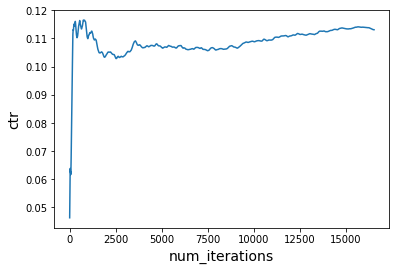

In [24]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'

# get the movielens data
data = get_movielens_data(url)

# filter the data
filtered_data = filter_data(data)

# index the data
indexed_data, user_indexer, movie_indexer = index_data(filtered_data)

# sort the data by timestamp
indexed_data_sorted = sorted(indexed_data, key=lambda x: x[3])

# instantiate the dictionary that would hold all the past actions of each user
# initial state is 0
actions_dict = {}
for i in indexed_data_sorted:
    if i[0] not in actions_dict:
        actions_dict[i[0]] = [0]
        
# instantiate the bandit
independent_bandits = IndependentBandits(
    num_arms=len(movie_indexer),
    num_ranks=10,  # Recommend the best 10 mvies
    bandit_class=DirichletThompsonSampling
)

sum_binary = 0.0
ctr_list = []
k = 100
i = 1
for d in tqdm(indexed_data_sorted):
    ground_truth = [d[1]]

    selected_items = independent_bandits.choose(context={'previous_action': actions_dict[d[0]][-1]})
    actions_dict[d[0]] += ground_truth
    hit_rate = len(set(ground_truth).intersection(set(selected_items))) / len(set(ground_truth))

    feedback_list = [1.0 if _item in ground_truth else 0.0 for _item in selected_items]
    independent_bandits.update(selected_items, feedback_list)

    binary_relevancy = 1.0 if hit_rate > 0 else 0.0
    sum_binary += binary_relevancy
    ctr_list.append(sum_binary / i)
    i += 1
ctr_avg = running_mean(ctr_list, k)

print('Average CTR at the last ' + str(k) + ' time steps: ' + str(ctr_avg[-1]))

plot_ctr(len(ctr_avg), ctr_avg).show()
